In [168]:
import azureml.core
from azureml.core import Workspace

# Load the workspace from the saved config file
ws = Workspace.from_config()
print('Ready to use Azure ML {} to work with {}'.format(azureml.core.VERSION, ws.name))

Ready to use Azure ML 1.28.0 to work with mlops


In [169]:
import os
from pathlib import Path

# Get experiment folder
experiment_folder = Path(os.getcwd()).parent
print(experiment_folder)

/mnt/batch/tasks/shared/LS_root/mounts/clusters/gpu-mlops/code/Users/s147056/image-restoration


In [170]:
model = ws.models['image_resto']
print(model.name, 'version', model.version)

image_resto version 3


## Deploy

In [171]:
from azureml.core.webservice import AciWebservice
from azureml.core.model import InferenceConfig
from azureml.core import Environment, Model

env = Environment.from_pip_requirements('image_resto_env', os.path.join(experiment_folder, 'requirements.txt'))

# Set path for scoring script
script_file = os.path.join(experiment_folder, "src", "deploy", "score.py")

# Configure the scoring environment
inference_config = InferenceConfig(entry_script=script_file,
                                   environment=env)



deployment_config = AciWebservice.deploy_configuration(cpu_cores = 1, memory_gb = 1)

service_name = "image-reconstruction-service"
if service_name in ws.webservices:
    ws.webservices[service_name].delete()


service = Model.deploy(ws, service_name, [model], inference_config, deployment_config)

service.wait_for_deployment(True)
print(service.state)

Tips: You can try get_logs(): https://aka.ms/debugimage#dockerlog or local deployment: https://aka.ms/debugimage#debug-locally to debug if deployment takes longer than 10 minutes.
Running
2021-06-16 13:07:40+00:00 Creating Container Registry if not exists.
2021-06-16 13:07:40+00:00 Registering the environment.
2021-06-16 13:07:42+00:00 Generating deployment configuration.
2021-06-16 13:07:43+00:00 Submitting deployment to compute..
2021-06-16 13:07:47+00:00 Checking the status of deployment image-reconstruction-service.

KeyboardInterrupt: 

In [135]:
print(service.get_logs())

2021-06-16T12:50:22,008030000+00:00 - gunicorn/run 
2021-06-16T12:50:22,014318700+00:00 - iot-server/run 
2021-06-16T12:50:22,014927800+00:00 - rsyslog/run 
2021-06-16T12:50:22,307181300+00:00 - nginx/run 
EdgeHubConnectionString and IOTEDGE_IOTHUBHOSTNAME are not set. Exiting...
2021-06-16T12:50:23,134266500+00:00 - iot-server/finish 1 0
2021-06-16T12:50:23,143018300+00:00 - Exit code 1 is normal. Not restarting iot-server.
Starting gunicorn 20.1.0
Listening at: http://127.0.0.1:31311 (83)
Using worker: sync
worker timeout is set to 300
Booting worker with pid: 112
SPARK_HOME not set. Skipping PySpark Initialization.
Initializing logger
2021-06-16 12:50:28,563 | root | INFO | Starting up app insights client
2021-06-16 12:50:28,564 | root | INFO | Starting up request id generator
2021-06-16 12:50:28,564 | root | INFO | Starting up app insight hooks
2021-06-16 12:50:28,564 | root | INFO | Invoking user's init function
/var/azureml-app/azureml-models/image_resto/3
2021-06-16 12:50:29,075

In [138]:
import json
import torch
import matplotlib.pyplot as plt

x_new = torch.rand(1, 224, 224)*255

# Convert the array to a serializable list in a JSON document
input_json = json.dumps({"data": x_new.tolist()})

# Call the web service, passing the input data (the web service will also accept the data in binary format)
reconstruction = service.run(input_data = input_json)

# Get the predicted class - it'll be the first (and only) one.
reconstruction = json.loads(reconstruction)

TypeError: Image data of dtype object cannot be converted to float

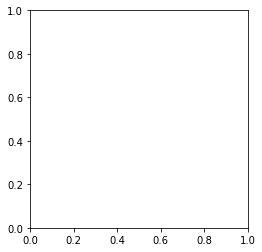

In [139]:
%matplotlib inline
plt.imshow(reconstruction*255)

In [148]:
import numpy as np

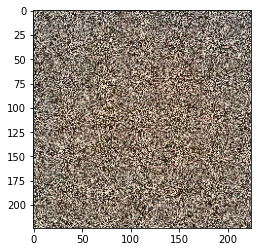

In [167]:

def get_rbg_from_lab(gray_imgs, ab_imgs, n = 10):
    # create an empty array to store images
    imgs = np.zeros((n, 224, 224, 3))

    imgs[:, :, :, 0] = gray_imgs[0:n:]
    imgs[:, :, :, 1:] = ab_imgs[0:n:]

    # convert all the images to type unit8
    imgs = imgs.astype("uint8")

    # create a new empty array
    imgs_ = []

    for i in range(0, n):
        imgs_.append(cv2.cvtColor(imgs[i], cv2.COLOR_LAB2RGB))

    # convert the image matrix into a numpy array
    imgs_ = np.array(imgs_)

    return imgs_

import cv2

img = get_rbg_from_lab((x_new).view(1, 224, 224),
                         (torch.tensor(reconstruction[0])*255).view(1, 224, 224, 2),
                         n=1)

plt.imshow(img.squeeze())